# Prediction Model to Decide Who will Win Between Two World Cup Nations


In [1]:
import pandas as pd
import os

os.chdir('/Users/pierlim/PycharmProjects/fifa18_final16')
#os.chdir('/home/pier/Machine_Learning/fifa18_final16')
df_results = pd.read_csv('data/results.csv')
df_results = df_results[df_results['date'] > '2015-1-1']
df_results.head()
# df_new = df_results[(df_results['home_team'].str.contains("Germany")) | (df_results['away_team'].str.contains("Germany"))]
# df_new

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
37119,2015-10-02,Oman,Syria,2,1,Friendly,Muscat,Oman,False
37120,2015-10-03,Jordan,Iraq,3,0,Friendly,Amman,Jordan,False
37121,2015-10-07,Comoros,Lesotho,0,0,FIFA World Cup qualification,Moroni,Comoros,False
37122,2015-10-07,Mauritius,Kenya,2,5,FIFA World Cup qualification,Mapou,Mauritius,False
37123,2015-10-07,Seychelles,Burundi,0,1,FIFA World Cup qualification,Roche Caiman,Seychelles,False


In [2]:
os.chdir('/Users/pierlim/PycharmProjects/fifa18_final16')
# os.chdir('/home/pier/Machine_Learning/fifa18_final16')
df_rankings = pd.read_csv('data/fifa_ranking.csv')
df_rankings = df_rankings[df_rankings['rank_date'].str.contains('2018')]
df_rankings =df_rankings.groupby('country_full')['rank', 'cur_year_avg_weighted'].mean()
df_rankings
# df_test = pd.DataFrame(df_test)
# df_test.reset_index()
df_rankings['country_full'] = df_rankings.index
# df_test[df_test['country_full'].str.contains('Germany')]
# df_test


# Join into the main dataset and cleaning

In [3]:
df_combined = df_results.set_index('home_team').join(df_rankings.set_index('country_full'))
df_combined.rename(columns={'rank' : 'home_rank', 'cur_year_avg_weighted' : 'home_weighted_points'}, inplace=True)
df_combined['home_team'] = df_combined.index
df_combined = df_combined.set_index('away_team').join(df_rankings.set_index('country_full'))
df_combined.rename(columns={'rank' : 'away_rank', 'cur_year_avg_weighted' : 'away_weighted_points'}, inplace=True)
df_combined['away_team'] = df_combined.index

Drop scores, and only use win/lose as the predictor.
Remove friendly and drawn matches. 

In [17]:
df_combined = df_combined.dropna()
df_combined = df_combined[~df_combined['tournament'].str.contains('Friendly')]
df_combined = df_combined[~(df_combined['home_score']==df_combined['away_score'])]
df_combined.head()


,date,home_score,away_score,tournament,city,country,neutral,home_rank,home_weighted_points,home_team,away_rank,away_weighted_points,away_team
Afghanistan,2015-12-26,0,3,SAFF Cup,Thiruvananthapuram,India,True,185.833333,0.000000,Bhutan,145.166667,104.065,Afghanistan
Afghanistan,2017-06-13,1,0,AFC Asian Cup qualification,Phnom Penh,Cambodia,False,169.833333,42.690000,Cambodia,145.166667,104.065,Afghanistan
Afghanistan,2016-01-03,2,1,SAFF Cup,Thiruvananthapuram,India,False,99.000000,202.945000,India,145.166667,104.065,Afghanistan
Afghanistan,2016-03-24,5,0,FIFA World Cup qualification,Saitama,Japan,False,57.833333,220.966667,Japan,145.166667,104.065,Afghanistan
Afghanistan,2017-09-05,4,1,AFC Asian Cup qualification,Amman,Jordan,False,115.166667,140.725000,Jordan,145.166667,104.065,Afghanistan


Removal of the non-world cup matches seems to aid prediction

In [18]:
df_combined = df_combined[df_combined['tournament'].str.contains('World')]

# Feature generation

In [19]:
# Taking home team to be the one we are interested in 
df_combined['won'] = (df_combined['home_score'] - df_combined['away_score']) >= 1
df_combined.drop(['date', 'city', 'country','home_score','away_score'], axis=1, inplace=True)

In [20]:
df_combined['rank_diff'] = df_combined['home_rank'] - df_combined['away_rank']

In [21]:
df_combined['point_diff'] = df_combined['home_weighted_points'] - df_combined['away_weighted_points']
df_combined.head()

,tournament,neutral,home_rank,home_weighted_points,home_team,away_rank,away_weighted_points,away_team,won,rank_diff,point_diff
Afghanistan,FIFA World Cup qualification,False,57.833333,220.966667,Japan,145.166667,104.065000,Afghanistan,True,-87.333333,116.901667
Afghanistan,FIFA World Cup qualification,False,171.666667,31.260000,Singapore,145.166667,104.065000,Afghanistan,True,26.500000,-72.805000
Afghanistan,FIFA World Cup qualification,True,75.000000,232.328333,Syria,145.166667,104.065000,Afghanistan,True,-70.166667,128.263333
Albania,FIFA World Cup qualification,False,96.666667,60.405000,Israel,57.833333,243.603333,Albania,False,38.833333,-183.198333
Albania,FIFA World Cup qualification,False,16.833333,440.005000,Italy,57.833333,243.603333,Albania,True,-41.000000,196.401667


In [22]:
df_combined.dtypes



tournament               object
neutral                    bool
home_rank               float64
home_weighted_points    float64
home_team                object
away_rank               float64
away_weighted_points    float64
away_team                object
won                        bool
rank_diff               float64
point_diff              float64
dtype: object

In [23]:
df_combined['won'] = df_combined['won'].astype(int)

# Data Balancing

In [28]:
from sklearn.utils import resample

df = df_combined
# Separate majority and minority classes
df_majority = df[df.won==1]
df_minority = df[df.won==0]
df_majority.shape


(336, 11)

In [29]:
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=336,    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
df_upsampled.won.value_counts()
df_combined = df_upsampled

# Model Building

In [56]:
y = df_combined['won']
X = df_combined.drop(['won'], axis=1)

# Preprocessing one hot
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

X_cat = X.select_dtypes(include=[object, bool])
le = LabelEncoder()
X_cat_labelled = X_cat.apply(le.fit_transform)
X_cat_labelled.head()
X = pd.concat([X,pd.get_dummies(X_cat_labelled['home_team'], prefix='home_team')],axis=1)
X = pd.concat([X,pd.get_dummies(X_cat_labelled['away_team'], prefix='away_team')],axis=1)
X = X.drop(['tournament', 'neutral','home_team', 'away_team'], axis=1)
# X = pd.concat([X, X_cat_labelled], axis=1)
y = le.fit_transform(y)
# X.head()
X.to_csv('home_away_reference_new.csv')
# # X.hist()
# # plt.show()
# # pd.DataFrame(y).hist()
# # plt.show()

In [57]:
X


,home_rank,home_weighted_points,away_rank,away_weighted_points,rank_diff,point_diff,home_team_0,home_team_1,home_team_2,home_team_3,...,away_team_146,away_team_147,away_team_148,away_team_149,away_team_150,away_team_151,away_team_152,away_team_153,away_team_154,away_team_155
Afghanistan,57.833333,220.966667,145.166667,104.065000,-87.333333,116.901667,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Afghanistan,171.666667,31.260000,145.166667,104.065000,26.500000,-72.805000,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Afghanistan,75.000000,232.328333,145.166667,104.065000,-70.166667,128.263333,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Albania,16.833333,440.005000,57.833333,243.603333,-41.000000,196.401667,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Albania,7.333333,608.915000,57.833333,243.603333,-50.500000,365.311667,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Algeria,49.500000,256.278333,61.500000,212.300000,-12.000000,43.978333,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Algeria,49.500000,280.283333,61.500000,212.300000,-12.000000,67.983333,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Algeria,76.166667,240.431667,61.500000,212.300000,14.666667,28.131667,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Andorra,94.500000,127.305000,132.833333,204.265000,-38.333333,-76.960000,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Andorra,50.500000,193.130000,132.833333,204.265000,-82.333333,-11.135000,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Correlation Matrix

In [58]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix
corr = df_combined.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [59]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.head()

,home_rank,home_weighted_points,away_rank,away_weighted_points,rank_diff,point_diff,home_team_0,home_team_1,home_team_2,home_team_3,...,away_team_146,away_team_147,away_team_148,away_team_149,away_team_150,away_team_151,away_team_152,away_team_153,away_team_154,away_team_155
Greece,200.833333,17.080000,44.833333,339.456667,156.000000,-322.376667,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Iraq,125.500000,109.980000,86.333333,242.390000,39.166667,-132.410000,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Canada,62.666667,284.306667,85.500000,230.703333,-22.833333,53.603333,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
India,121.333333,157.960000,99.000000,202.945000,22.333333,-44.985000,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Tahiti,166.833333,32.515000,156.166667,48.875000,10.666667,-16.360000,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Do logistic regression with cross validation first

In [60]:
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.ensemble import RandomForestClassifier

# logreg = linear_model.LogisticRegression(C=0.013)
# features = PolynomialFeatures(degree=3)
# model = Pipeline([
#     ('polynomial_features', features),
#     ('logistic_regression', logreg)
# ])
# model = model.fit(X_train, y_train)

# Bayesian
# model = GaussianNB()
# model = model.fit(X_train, y_train)

# Random Forest
model = RandomForestClassifier(max_depth=3, random_state=0)
model.fit(X_train, y_train)


# clf = linear_model.LogisticRegression(C=0.013)
# # log_fit = clf.fit(X_train, y_train)
# # log_fit.score(X_test, y_test)
scores = cross_val_score(model, X_train, y_train, cv=5)
scores

array([ 0.81481481,  0.88888889,  0.73148148,  0.8411215 ,  0.77358491])

In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

Test on test data

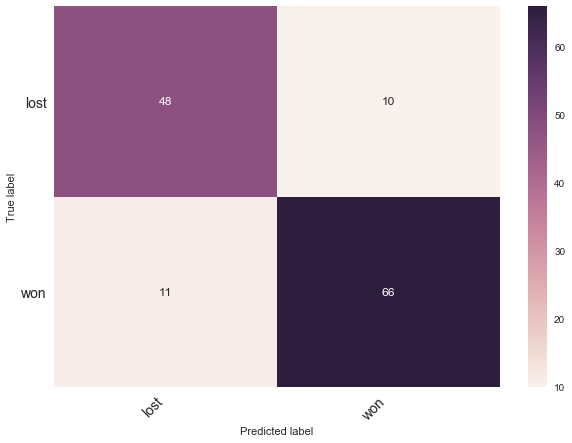

In [62]:
from sklearn import metrics
#model.score(X_test, y_test)
pred = model.predict(X_test)
cm = metrics.confusion_matrix(y_test, pred )
print_confusion_matrix(cm, ['lost', 'won'])

In [63]:
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support, accuracy_score

print('area under curve: {}'.format(roc_auc_score(y_test, pred)))
print('accuracy: {}'.format(accuracy_score(y_test, pred)))
precision, recall, fscore, support = precision_recall_fscore_support(y_test, pred)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

area under curve: 0.8423645320197045
accuracy: 0.8444444444444444
precision: [ 0.81355932  0.86842105]
recall: [ 0.82758621  0.85714286]
fscore: [ 0.82051282  0.8627451 ]
support: [58 77]


In [64]:
# Bayesian 0.71106382978723404
# Logistic 0.74416413373860191
X_train.to_csv('X_train.csv')
X_test.to_csv('X_test.csv')

# Let's Predict Tonight's Match! Germany vs South Korea!

In [69]:
df_germany = pd.read_csv('data/Y_Germany.csv') # Pre-created data for Germany vs South Korea

In [70]:
df_germany


,NA,home_rank,home_weighted_points,away_rank,away_weighted_points,rank_diff,point_diff,home_team_0,home_team_1,home_team_2,...,away_team_146,away_team_147,away_team_148,away_team_149,away_team_150,away_team_151,away_team_152,away_team_153,away_team_154,away_team_155
0,NaN,1,822.736667,59.166667,183.176667,-58.166667,639.560000,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,NaN,16,183.176667,21.000000,578.833333,-5.000000,-395.656667,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [71]:
df_germany = df_germany.drop(df_germany.columns[0], axis=1) # drop NA column

In [72]:
answer = model.predict(df_germany)

In [73]:
print(answer)

[1 0]


# Hence Germany is predicted to win tonight's match against South Korea, with 77% accuracy. 

Mexico is predicted to lose to Sweden as well. 